In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from glob import glob
from src.data.handlers import DataLoader
from src.models.regression.train_models import RegressionTraining
from src.utils import denorm
from src.utils.constants import FEATURES_NAMES, FLUID_COMPONENTS, K_FOLDS, REGRESSION_TARGET_NAMES
from src.visualization.styles.formatting import errorbar_kwargs

In [13]:
data_loader = DataLoader()
datasets, min_max = data_loader.load_cross_validation_datasets(problem="regression")

valid_datasets = datasets["valid"]
training = RegressionTraining()
results = training.load_training_models()

In [14]:
def absolute_error(y_true: np.ndarray, y_pred: np.ndarray):
    return np.abs(y_true - y_pred)

def phase_components_histogram(phase, model_type):
    f, axs = plt.subplots(6, 4, sharey=True, figsize=(8, 11))
    for i in range(indices[model_type][f"{phase}_error"].shape[2]):
        ax = axs[i//4, i%4]
        ax.hist(indices[model_type][f"{phase}_error"][:,:,i].flatten())
        title = "${}_{{{}}}$"
        ax.set_title(title.format(phase, FLUID_COMPONENTS[i]), pad=5)
        ax.grid()
    f.subplots_adjust(hspace=0.6, wspace=0.2)
    return f

# Regression models
model = [m for m in results["outputs"] if m["model_id"] == 13][0]

# Regression models with soft constraint on loss function
constrained_models = [None for _ in range(4)]
folder = os.path.join("data", "models", "regression_with_constrained_loss", "saved_results")
for model_filepath in glob(os.path.join(folder, "*model_id=3*.keras")):
    _, model_filename = os.path.split(model_filepath)
    fold_index = int(model_filename[27])
    constrained_models[fold_index] = tf.keras.models.load_model(model_filepath)

indices = {
    "model": {
        "x_hats": np.zeros((4, 19, 24)),
        "y_hats": np.zeros((4, 19, 24)),
        "x_error": np.zeros((4, 19, 24)),
        "y_error": np.zeros((4, 19, 24)),
        "nV_error": np.zeros((4, 19)),
    },
    "constrained_model": {
        "x_hats": np.zeros((4, 19, 24)),
        "y_hats": np.zeros((4, 19, 24)),
        "x_error": np.zeros((4, 19, 24)),
        "y_error": np.zeros((4, 19, 24)),
        "nV_error": np.zeros((4, 19)),
    }
}

for i, (result, valid_data) in enumerate(zip(model["folds"], valid_datasets)):
    valid_features, valid_labels = valid_data["features"], valid_data["targets"]

    z = valid_features.loc[:, FEATURES_NAMES[:-2]].values

    X_valid = tf.convert_to_tensor(valid_features)
    Y_valid = denorm(valid_labels.to_numpy(), *min_max[i])
    K = Y_valid[:, :-1]
    nV = Y_valid[:, -1:]
    x = z / (1 + nV * (K - 1))
    y = K * x

    # Regression models
    model = result["model"]

    Y_hat_valid = denorm(model(X_valid).numpy(), *min_max[i])
    K_hat = Y_hat_valid[:, :-1]
    nV_hat = Y_hat_valid[:, -1:]
    x_hat = z / (1 + nV_hat * (K_hat - 1))
    y_hat = K_hat * x_hat

    indices["model"]["x_hats"][i, :, :] = x_hat
    indices["model"]["y_hats"][i, :, :] = y_hat
    indices["model"]["x_error"][i, :, :] = absolute_error(x, x_hat)
    indices["model"]["x_error"][i, :, :] = absolute_error(x, x_hat)
    indices["model"]["y_error"][i, :, :] = absolute_error(y, y_hat)
    indices["model"]["nV_error"][i, :] = absolute_error(nV, nV_hat).flatten()

    # Regression with soft constraint models
    constrained_model = constrained_models[i]

    Y_hat_valid = denorm(constrained_model(X_valid).numpy(), *min_max[i])
    K_hat = Y_hat_valid[:, :-1]
    nV_hat = Y_hat_valid[:, -1:]
    x_hat = z / (1 + nV_hat * (K_hat - 1))
    y_hat = K_hat * x_hat

    indices["constrained_model"]["x_hats"][i, :, :] = x_hat
    indices["constrained_model"]["y_hats"][i, :, :] = y_hat
    indices["constrained_model"]["x_error"][i, :, :] = absolute_error(x, x_hat)
    indices["constrained_model"]["x_error"][i, :, :] = absolute_error(x, x_hat)
    indices["constrained_model"]["y_error"][i, :, :] = absolute_error(y, y_hat)
    indices["constrained_model"]["nV_error"][i, :] = absolute_error(nV, nV_hat).flatten()

### Frações das componentes na fase líquida $x_i$

In [15]:
model_type = "constrained_model"

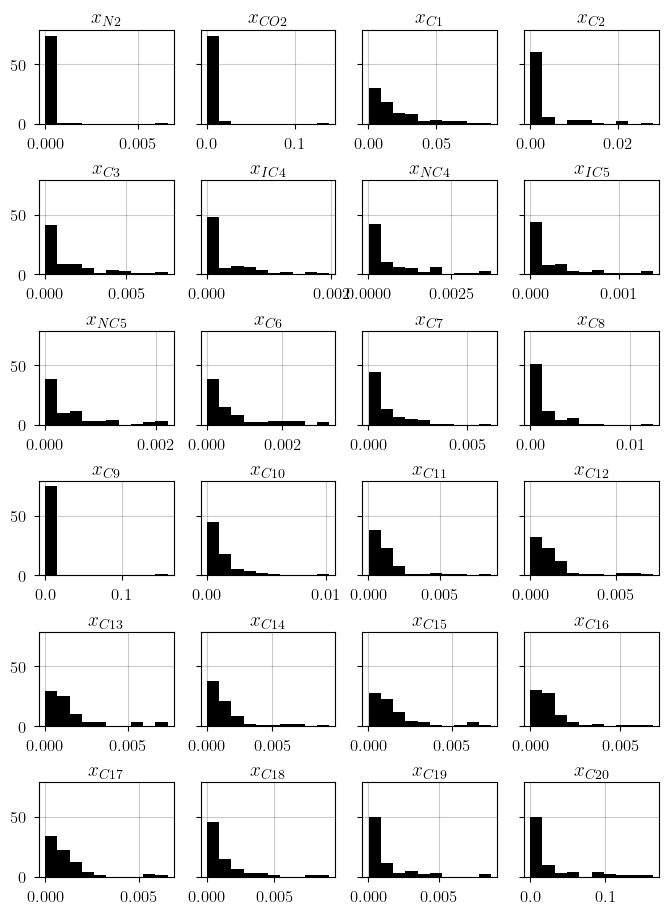

In [16]:
f = phase_components_histogram(phase="x", model_type=model_type)
f.savefig(os.path.join("data", "images", f"histogram_errorx_per_component_{model_type}.png"), dpi=600, bbox_inches="tight")

[0.0002 0.0037 0.0237 0.0058 0.0064 0.0015 0.0034 0.0011 0.0016 0.0019
 0.0016 0.0021 0.0019 0.0018 0.0017 0.0018 0.002  0.0023 0.0023 0.002
 0.0021 0.0023 0.0023 0.0428]
[0.     0.001  0.0033 0.0012 0.0014 0.0003 0.0007 0.0002 0.0004 0.0005
 0.0004 0.0004 0.0003 0.0003 0.0003 0.0003 0.0004 0.0003 0.0003 0.0003
 0.0002 0.0002 0.0002 0.0048]
[0.0002 0.0033 0.0198 0.003  0.0015 0.0003 0.0007 0.0003 0.0005 0.0006
 0.0009 0.0014 0.0034 0.0013 0.0013 0.0013 0.0015 0.0015 0.0014 0.0011
 0.0011 0.0013 0.0012 0.0257]
[0.0001 0.0018 0.0018 0.0006 0.0002 0.     0.0001 0.     0.     0.
 0.0001 0.0002 0.002  0.0002 0.0002 0.0002 0.0002 0.0002 0.0001 0.0001
 0.     0.0001 0.0001 0.0012]


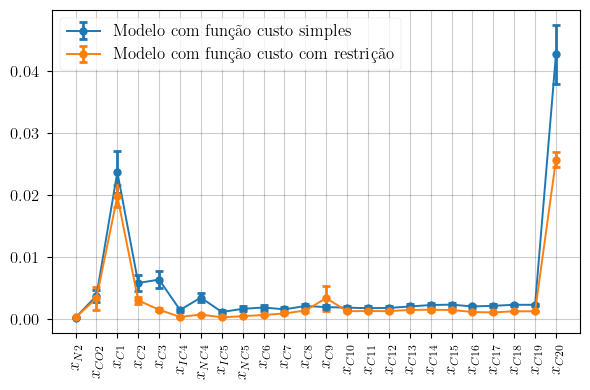

In [24]:
x = np.array([i + 1 for i in np.arange(len(REGRESSION_TARGET_NAMES[:-1]))])
x_mae1 = indices["model"]["x_error"].mean(axis=1)
x_mae2 = indices["constrained_model"]["x_error"].mean(axis=1)

f, ax = plt.subplots(figsize=(6, 4))

y = x_mae1.mean(axis=0)
y_err = x_mae1.std(axis=0) / np.sqrt(K_FOLDS - 1)
print(y)
print(y_err)
ax.errorbar(x, y, y_err, c="tab:blue", label="Modelo com função custo simples", **errorbar_kwargs)

y = x_mae2.mean(axis=0)
y_err = x_mae2.std(axis=0) / np.sqrt(K_FOLDS - 1)
print(y)
print(y_err)
ax.errorbar(x, y, y_err, c="tab:orange", label="Modelo com função custo com restrição", **errorbar_kwargs)

ax.grid()
ax.legend()

def fix_ticks(name):
    _, component = name.split("_")
    return "$x_{" + component + "}$"

ticks = [fix_ticks(name) for name in REGRESSION_TARGET_NAMES[:-1]]
ax.set_xticks(x, ticks, rotation=90, ha="center")
f.tight_layout()
f.savefig(os.path.join("data", "images", f"plot_errorx_per_component_{model_type}.png"), dpi=600, bbox_inches="tight")

### Frações das componentes na fase vapor $y_i$

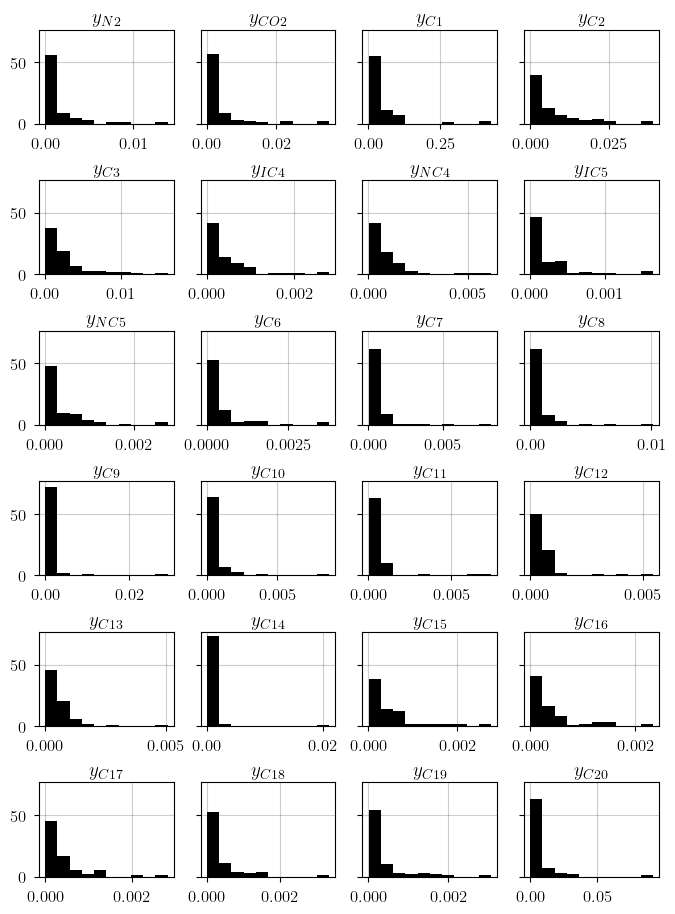

In [18]:
f = phase_components_histogram(phase="y", model_type=model_type)
f.savefig(os.path.join("data", "images", f"histogram_errory_per_component_{model_type}.png"), dpi=600, bbox_inches="tight")

[0.0015 0.008  0.1779 0.0144 0.0116 0.0024 0.0049 0.0014 0.0022 0.0022
 0.0018 0.0017 0.0017 0.0009 0.0007 0.0007 0.0007 0.0009 0.0008 0.0006
 0.0005 0.0005 0.0005 0.0084]
[0.0005 0.0017 0.0547 0.0014 0.0012 0.0003 0.0004 0.0002 0.0003 0.0004
 0.0003 0.0002 0.0006 0.0001 0.0001 0.0001 0.     0.0002 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0016]
[0.0013 0.0034 0.044  0.0071 0.0027 0.0004 0.0008 0.0002 0.0004 0.0005
 0.0006 0.0008 0.001  0.0006 0.0006 0.0005 0.0005 0.0007 0.0005 0.0004
 0.0003 0.0003 0.0003 0.0058]
[0.0006 0.0007 0.0123 0.002  0.0004 0.0001 0.0001 0.     0.     0.
 0.0001 0.0001 0.0003 0.0001 0.0001 0.0001 0.0001 0.0002 0.0001 0.
 0.     0.     0.     0.0011]


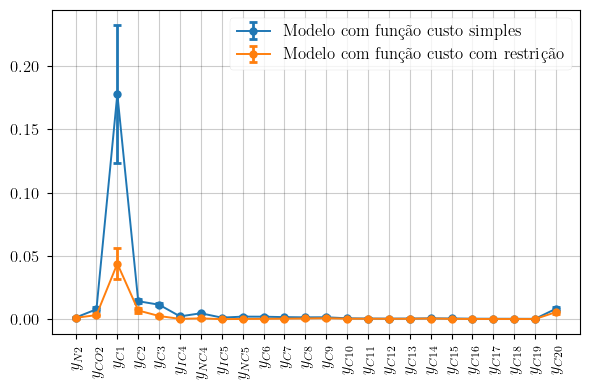

In [25]:
x = np.array([i + 1 for i in np.arange(len(REGRESSION_TARGET_NAMES[:-1]))])
y_mae1 = indices["model"]["y_error"].mean(axis=1)
y_mae2 = indices["constrained_model"]["y_error"].mean(axis=1)

f, ax = plt.subplots(figsize=(6, 4))

y = y_mae1.mean(axis=0)
y_err = y_mae1.std(axis=0) / np.sqrt(K_FOLDS - 1)
print(y)
print(y_err)
ax.errorbar(x, y, y_err, c="tab:blue", label="Modelo com função custo simples", **errorbar_kwargs)

y = y_mae2.mean(axis=0)
y_err = y_mae2.std(axis=0) / np.sqrt(K_FOLDS - 1)
print(y)
print(y_err)
ax.errorbar(x, y, y_err, c="tab:orange", label="Modelo com função custo com restrição", **errorbar_kwargs)

ax.grid()
ax.legend()

def fix_ticks(name):
    _, component = name.split("_")
    return "$y_{" + component + "}$"

ticks = [fix_ticks(name) for name in REGRESSION_TARGET_NAMES[:-1]]
ax.set_xticks(x, ticks, rotation=90, ha="center")
f.tight_layout()
f.savefig(os.path.join("data", "images", f"plot_errory_per_component_{model_type}.png"), dpi=600, bbox_inches="tight")

### Fração de vapor $n_V$

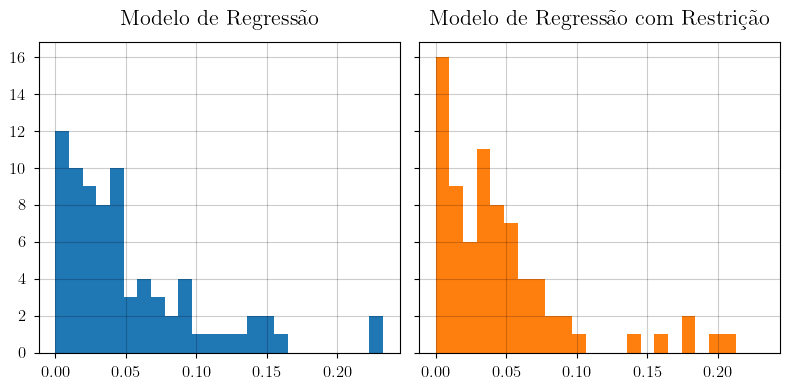

In [31]:
nV_error_vec = indices["model"]["nV_error"].flatten()
bins = np.linspace(nV_error_vec.min(), nV_error_vec.max(), num=25)

f, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
axs[0].hist(indices["model"]["nV_error"].flatten(), bins=bins, color="tab:blue")
axs[1].hist(indices["constrained_model"]["nV_error"].flatten(), bins=bins, color="tab:orange")
axs[0].set_title("Modelo de Regressão", size=16)
axs[1].set_title("Modelo de Regressão com Restrição", size=16)

for ax in axs:
    ax.grid()

# f.suptitle("Desvio absoluto da fração de vapor $n_V$")
f.tight_layout()
f.savefig(os.path.join("data", "images", f"histogram_errornv.png"), dpi=600, bbox_inches="tight")

### Somatório das frações das componentes $x$ e $y$

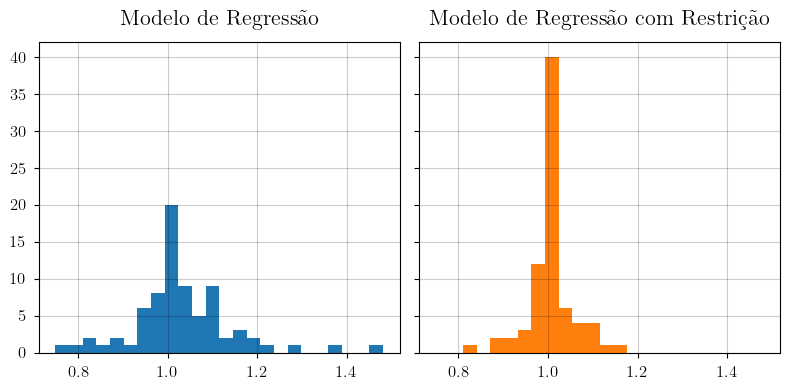

In [32]:
x_hat_vec = indices["model"]["x_hats"].sum(axis=2).flatten()
bins = np.linspace(x_hat_vec.min(), x_hat_vec.max(), num=25)

f, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
axs[0].hist(indices["model"]["x_hats"].sum(axis=2).flatten(), bins=bins, color="tab:blue")
axs[1].hist(indices["constrained_model"]["x_hats"].sum(axis=2).flatten(), bins=bins, color="tab:orange")
axs[0].set_title("Modelo de Regressão", size=16)
axs[1].set_title("Modelo de Regressão com Restrição", size=16)

for ax in axs:
    ax.grid()

# f.suptitle("Somatório das componentes de $\\mathbf{x}$")
f.tight_layout()
f.savefig(os.path.join("data", "images", f"histogram_errorsumx.png"), dpi=600, bbox_inches="tight")

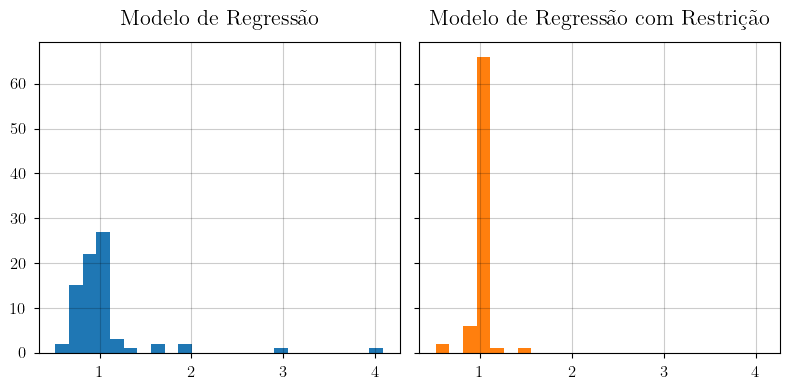

In [33]:
y_hat_vec = indices["model"]["y_hats"].sum(axis=2).flatten()
bins = np.linspace(y_hat_vec.min(), y_hat_vec.max(), num=25)

f, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
axs[0].hist(indices["model"]["y_hats"].sum(axis=2).flatten(), bins=bins, color="tab:blue")
axs[1].hist(indices["constrained_model"]["y_hats"].sum(axis=2).flatten(), bins=bins, color="tab:orange")
axs[0].set_title("Modelo de Regressão", size=16)
axs[1].set_title("Modelo de Regressão com Restrição", size=16)

for ax in axs:
    ax.grid()

# f.suptitle("Somatório das componentes de $\\mathbf{y}$")
f.tight_layout()
f.savefig(os.path.join("data", "images", f"histogram_errorsumy.png"), dpi=600, bbox_inches="tight")

In [34]:
print("x fraction")
print("model")
y_hats = indices["model"]["x_hats"].sum(axis=2).mean(axis=1)
print(f"{y_hats.mean():.4f} +/- {y_hats.std() / np.sqrt(4 - 1):.4f}")

print("constrained model")
y_hats = indices["constrained_model"]["x_hats"].sum(axis=2).mean(axis=1)
print(f"{y_hats.mean():.4f} +/- {y_hats.std() / np.sqrt(4 - 1):.4f}")

print("\n\ny fraction")
print("model")
y_hats = indices["model"]["y_hats"].sum(axis=2).mean(axis=1)
print(f"{y_hats.mean():.4f} +/- {y_hats.std() / np.sqrt(4 - 1):.4f}")

print("constrained model")
y_hats = indices["constrained_model"]["y_hats"].sum(axis=2).mean(axis=1)
print(f"{y_hats.mean():.4f} +/- {y_hats.std() / np.sqrt(4 - 1):.4f}")

x fraction
model
1.0333 +/- 0.0160
constrained model
1.0051 +/- 0.0098


y fraction
model
1.0243 +/- 0.0951
constrained model
0.9955 +/- 0.0163
